In [1]:
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

In [2]:
texts, _ = fetch_20newsgroups( subset='all', remove=('headers', 'footers', 'quotes'), return_X_y=True )
tokenizer = lambda s: re.findall( '\w+', s.lower() )
texts = [ tokenizer(t) for t in  texts ]

# Creating some random topics
topics = [ ['space', 'planet', 'mars', 'galaxy'],
           ['cold', 'medicine', 'doctor', 'health', 'water'],
           ['cats', 'health', 'keyboard', 'car', 'banana'],
           ['windows', 'mac', 'computer', 'operating', 'system']
          ]

# Creating a dictionary with the vocabulary
word2id = Dictionary( texts )

# Coherence model
cm = CoherenceModel(topics=topics, 
                    texts=texts,
                    coherence='c_v',  
                    dictionary=word2id)

coherence_per_topic = cm.get_coherence_per_topic()

C:\Users\TEMP\AppData\Local\Temp\ipykernel_16740\2054869953.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


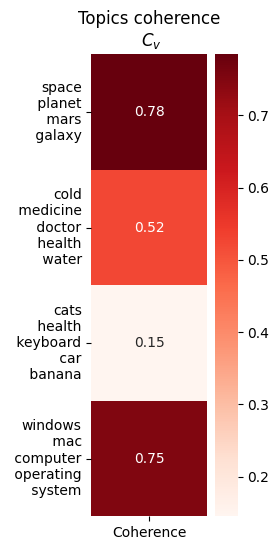

In [3]:
topics_str = [ '\n '.join(t) for t in topics ]
data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(2,6) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()